### Setup

In [ ]:
import torch
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE
import torch.nn.functional as F
from sae_lens import (
    SAE,
    HookedSAETransformer,
)
import matplotlib.pyplot as plt
import pickle
from huggingface_hub import notebook_login

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
notebook_login()
torch.set_grad_enabled(False)
device = "cuda"

In [3]:
gemma_9b: HookedSAETransformer = HookedSAETransformer.from_pretrained("gemma-2-9b", device=device)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b into HookedTransformer


### Helper Functions

In [ ]:
def get_feature_directions(selected_features, start_layer=23, end_layer=30):
    feature_directions = []
    for layer in range(start_layer, end_layer + 1):
        feature_idx = selected_features[layer][0].item()
        sae, cfg_dict_layer, sparsity_layer = SAE.from_pretrained(
            release='gemma-scope-9b-pt-res-canonical',
            sae_id=f"layer_{layer}/width_16k/canonical",
            device="cuda",
        )
        direction = sae.W_dec[feature_idx].detach().cpu()
        feature_directions.append(direction)
    return feature_directions

def compute_pairwise_cosine(feature_directions):
    n = len(feature_directions)
    cosine_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            sim = F.cosine_similarity(
                feature_directions[i].unsqueeze(0),
                feature_directions[j].unsqueeze(0),
                dim=-1
            ).item()
            cosine_matrix[i, j] = sim

    return cosine_matrix

def plot_heatmap(cosine_matrix, start_layer=23):
    labels = [f"L{l}" for l in range(start_layer, start_layer + cosine_matrix.shape[0])]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cosine_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", vmin=-1, vmax=1)
    plt.title("Pairwise Cosine Similarity of SAE Feature Directions (Layers 23–30)")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

def plot_clustermap(cosine_matrix, start_layer=23):
    labels = [f"L{l}" for l in range(start_layer, start_layer + cosine_matrix.shape[0])]
    
    # Convert to numpy if it's a torch tensor
    if not isinstance(cosine_matrix, np.ndarray):
        cosine_matrix = cosine_matrix.cpu().numpy()

    # Create a labeled DataFrame for clustering
    df = pd.DataFrame(cosine_matrix, index=labels, columns=labels)

    # Plot clustermap
    sns.clustermap(df, cmap="viridis", vmin=-1, vmax=1, annot=True, figsize=(8, 8))
    plt.suptitle("Clustered Cosine Similarity of SAE Feature Directions (Layers {}–{})".format(start_layer, start_layer + cosine_matrix.shape[0] - 1), y=1.02)
    plt.show()

def plot_similarity_to_reference(feature_directions, ref_layer=26, start_layer=23):
    ref_dir = feature_directions[ref_layer - start_layer]
    similarities = [
        F.cosine_similarity(ref_dir.unsqueeze(0), direction.unsqueeze(0), dim=-1).item()
        for direction in feature_directions
    ]
    layers = list(range(start_layer, start_layer + len(feature_directions)))
    plt.figure(figsize=(8, 4))
    plt.plot(layers, similarities, marker='o')
    plt.title(f"Cosine Similarity to Layer {ref_layer} SAE Feature")
    plt.xlabel("Layer")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- New: PCA projection of SAE directions across layers ---

def plot_pca_projection(feature_directions, start_layer=23):
    W = torch.stack(feature_directions).numpy()  # shape [n_layers, d]
    pca = PCA(n_components=2)
    coords = pca.fit_transform(W)
    explained = pca.explained_variance_ratio_
    print(f"Explained variance by PC1 and PC2: {explained[0]:.4f}, {explained[1]:.4f}")
    print(f"Total variance explained: {sum(explained):.4f}")
    plt.figure(figsize=(6, 5))
    plt.scatter(coords[:, 0], coords[:, 1])
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, f"{start_layer + i}", fontsize=9, ha='center', va='center')
    plt.title("PCA Projection of SAE Feature Directions (Layers {}–{})".format(start_layer, start_layer + len(feature_directions) - 1))
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_tsne_projection(feature_directions, start_layer=23, perplexity=5):
    W = torch.stack(feature_directions).numpy()  # shape [n_layers, d]
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    coords = tsne.fit_transform(W)
    
    plt.figure(figsize=(6, 5))
    plt.scatter(coords[:, 0], coords[:, 1])
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, f"{start_layer + i}", fontsize=9, ha='center', va='center')
    plt.title(f"t-SNE Projection of SAE Feature Directions (Layers {start_layer}–{start_layer + len(feature_directions) - 1})")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_umap_projection(feature_directions, start_layer=23, n_neighbors=5, min_dist=0.3):
    W = torch.stack(feature_directions).numpy()  # shape [n_layers, d]
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=0)
    coords = reducer.fit_transform(W)

    plt.figure(figsize=(6, 5))
    plt.scatter(coords[:, 0], coords[:, 1])
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, f"{start_layer + i}", fontsize=9, ha='center', va='center')
    plt.title(f"UMAP Projection of SAE Feature Directions (Layers {start_layer}–{start_layer + len(feature_directions) - 1})")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def generate_lang_sentences(lang = "cmn", size=100):
    lines = {"cmn": 29909, "jpn": 109964, "spa": 141543, "fra": 232736}
    prompts = []
    np.random.seed(42)
    sampled_indices = np.random.choice(lines[lang], size=size, replace=False)
    with open(f"/workspace/{lang}.txt", "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i in sampled_indices:
                parts = line.strip().split("\t")  # Split by tab
                if len(parts) >= 2:  # Ensure valid format
                    # english_prompts.append(parts[0])   # English sentence
                    prompts.append(parts[1])   # Spanish translation
    # print(prompts)
    return prompts

def rms_norm(x, eps=1e-5):
    # Gemma uses standard RMSNorm (no learned scale here since W_O handles scaling)
    return x / torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + eps)

def find_top_heads(layer, feature_direction, model, cache, top_k=5):
    """
    Find top attention heads that push in the Spanishness feature direction.

    Args:
        layer (int): which layer
        feature_direction (Tensor): [d_model] feature vector
        model (HookedTransformer): the model
        cache (ActivationCache): cache from run_with_cache
        top_k (int): number of top heads to return

    Returns:
        List of (head_idx, contribution) sorted descending
    """
    device = feature_direction.device
    W_O = model.blocks[layer].attn.W_O  # [n_heads, head_dim, d_model]

    attn_z = cache[f"blocks.{layer}.attn.hook_z"]  # [batch, seq_len, n_heads, head_dim]

    batch_size, seq_len, n_heads, head_dim = attn_z.shape
    d_model = model.cfg.d_model

    head_contributions = []

    for h in range(n_heads):
        z_head = attn_z[:, :, h, :]  # [batch, seq_len, head_dim]
        W_O_head = W_O[h]            # [head_dim, d_model]

        # Project head output through W_O
        attn_out_head = torch.einsum("bsh,hd->bsd", z_head, W_O_head)  # [batch, seq_len, d_model]

        # Apply RMSNorm across last dimension
        attn_out_head_normed = rms_norm(attn_out_head)  # same shape

        # Project onto feature direction
        proj = attn_out_head_normed @ feature_direction  # [batch, seq_len]
        feature_strength = proj.mean()  # scalar
        head_contributions.append(feature_strength.item())

    head_contributions = torch.tensor(head_contributions)

    # Find top_k heads by absolute contribution
    top = torch.topk(head_contributions.abs(), k=top_k)
    results = [(idx.item(), head_contributions[idx].item()) for idx in top.indices]

    for head_idx, contrib in results:
        print(f"Head {head_idx}: Contribution {contrib:.4f}")

    return results


def find_top_neurons(layer, feature_direction, model, top_k=10):
    """
    Find top MLP neurons that push along the Spanishness feature.

    Args:
        layer (int): layer number
        feature_direction (Tensor): [d_model]
        model (HookedTransformer): model
        top_k (int): number of top neurons

    Returns:
        List of (neuron_idx, contribution) sorted descending
    """
    # Load W_out for the MLP
    W_out = model.blocks[layer].mlp.W_out  # shape: [d_model, d_mlp]

    # Project feature_direction onto every neuron's output direction
    neuron_contributions = feature_direction @ W_out.T  # [d_mlp]

    # Top absolute contributors
    top = torch.topk(neuron_contributions.abs(), k=top_k)

    results = [(idx.item(), neuron_contributions[idx].item()) for idx in top.indices]

    # print(f"Top {top_k} MLP neurons at layer {layer} contributing to Spanishness:")
    for neuron_idx, contrib in results:
        print(f"Neuron {neuron_idx}: Contribution {contrib:.4f}")

    return results

### Similarity/Probability Plot

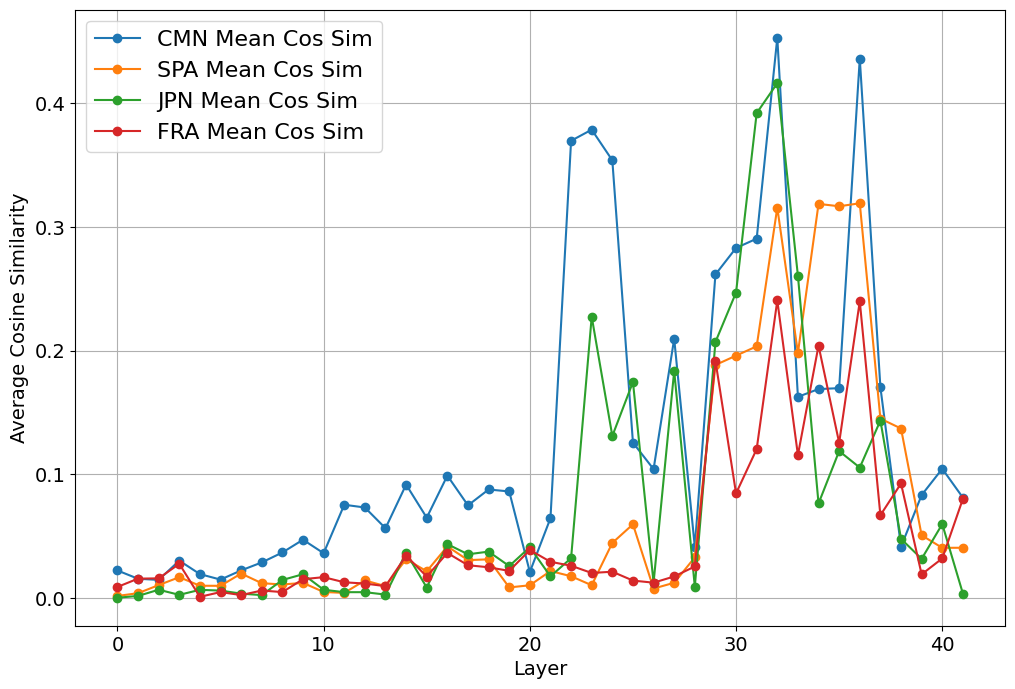

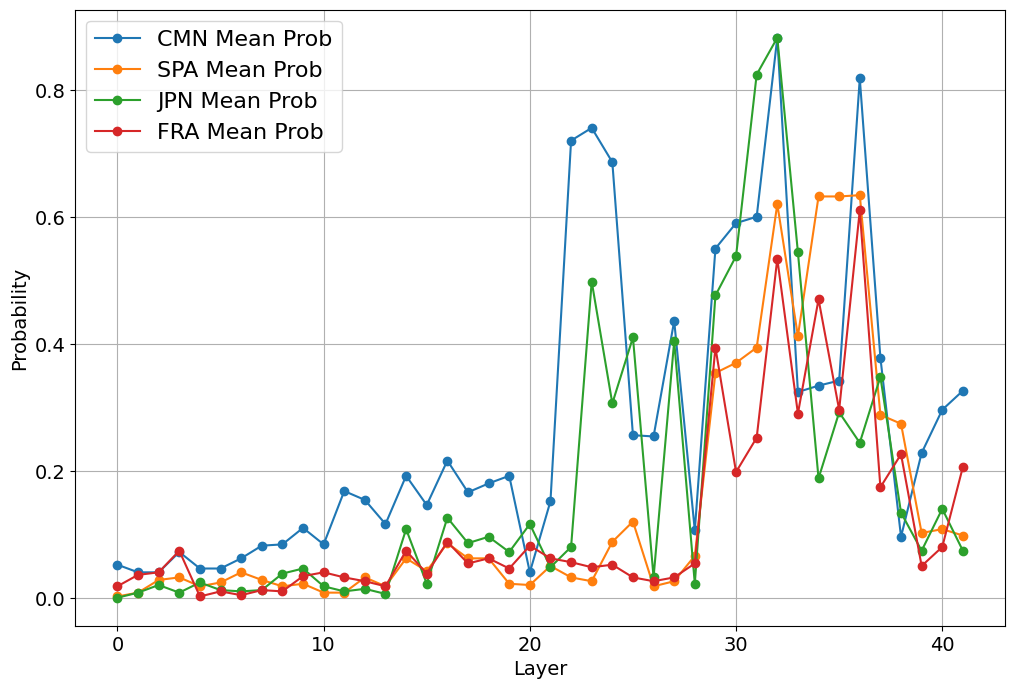

In [ ]:
languages = ["cmn", "spa", "jpn", "fra"]  # Chinese, Spanish, Japanese, French
# languages = ["spa"]
language_mean_selected = {}
language_last_selected = {}
for lang in languages:
    mean_selected = []
    last_selected = []

    for layer in range(42):
        # Load mean features
        with open(f"gemma9b_{lang}_similarity/similarity{layer}_mean_500.pkl", 'rb') as f:
            mean = pickle.load(f)

        # Load last features
        with open(f"gemma9b_{lang}_similarity/similarity{layer}_last_500.pkl", 'rb') as f:
            last = pickle.load(f)

        # Select feature for mean
        mean_scores = [score for (_, _, _, score, _) in mean]
        if all(s == 0 for s in mean_scores):
            selected_mean = mean[-1]  # Pick last
        else:
            selected_mean = mean[torch.argmax(torch.tensor(mean_scores)).item()]
        mean_selected.append(selected_mean)

        # Select feature for last
        last_scores = [score for (_, _, _, score, _) in last]
        if all(s == 0 for s in last_scores):
            selected_last = last[-1]
        else:
            selected_last = last[torch.argmax(torch.tensor(last_scores)).item()]
        last_selected.append(selected_last)

    language_mean_selected[lang] = mean_selected
    language_last_selected[lang] = last_selected

# Now plotting
layers = list(range(42))

# Plot 1: Scores
plt.figure(figsize=(12, 8))
for lang in languages:
    mean_selected_scores = [feature[3] for feature in language_mean_selected[lang]]
    last_selected_scores = [feature[3] for feature in language_last_selected[lang]]

    plt.plot(layers, mean_selected_scores, marker='o', label=f'{lang.upper()} Mean Cos Sim')
    # plt.plot(layers, last_selected_scores, marker='x', label=f'{lang.upper()} Last Cos Sim')

plt.xlabel('Layer', fontsize=14)
plt.ylabel('Average Cosine Similarity', fontsize=14)
# plt.title('Selected SAE Feature Scores Across Layers (4 Languages)')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

# Plot 2: Probabilities
plt.figure(figsize=(12, 8))
for lang in languages:
    mean_selected_probs = [feature[4] for feature in language_mean_selected[lang]]
    last_selected_probs = [feature[4] for feature in language_last_selected[lang]]

    plt.plot(layers, mean_selected_probs, marker='o', label=f'{lang.upper()} Mean Prob')
    # plt.plot(layers, last_selected_probs, marker='x', label=f'{lang.upper()} Last Prob')

plt.xlabel('Layer', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title('Selected SAE Feature Probabilities Across Layers (4 Languages)')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()
# print("\nSelected features (mean):")
# for layer, feature in enumerate(mean_selected):
#     print(f"Layer {layer}: {feature}")

# print("\nSelected features (last):")
# for layer, feature in enumerate(last_selected):
#     print(f"Layer {layer}: {feature}")

### Attention Head Contribution to Language Features

In [ ]:
layer = 30
sae, cfg_dict_layer, sparsity_layer = SAE.from_pretrained(
    release='gemma-scope-9b-pt-res-canonical',
    sae_id=f"layer_{layer}/width_16k/canonical",
    device=str(device),
)
languages = ["cmn", "jpn", "spa", "fra"]

for lang in languages:
    print(lang, " SENTENCES")
    _, cache = gemma_9b.run_with_cache(
            generate_lang_sentences(lang, 50),
    )
    for lang2 in languages:
        print(lang2, "directions")
        feature_direction = sae.W_dec[language_last_selected[lang2][layer][0]]
        top_heads = find_top_heads(
            layer=layer,
            feature_direction=feature_direction,
            model=gemma_9b,
            cache=cache,
            top_k=3
        )
    cache.to("cpu")
    del cache

### Residual Decomposition

Chinese

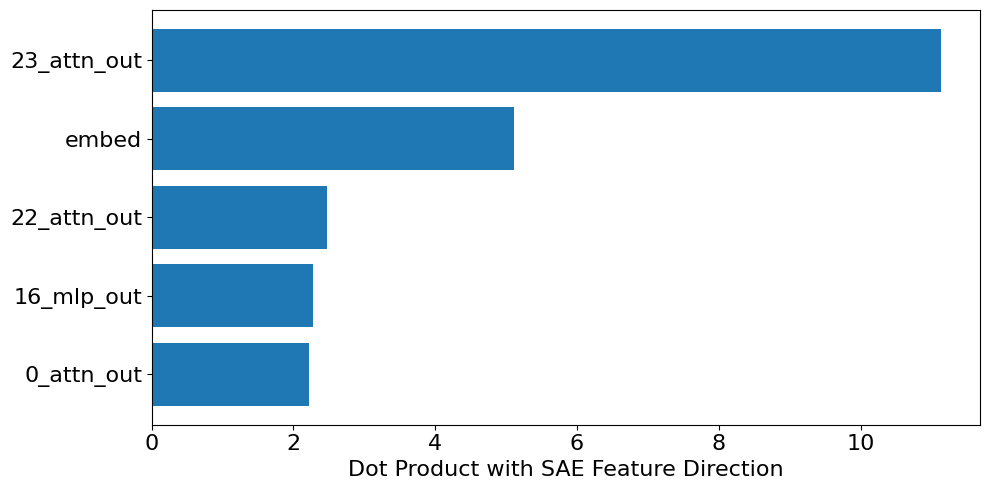

In [ ]:
%matplotlib inline
layer = 23

sae, _, _ = SAE.from_pretrained(
    release='gemma-scope-9b-pt-res-canonical',
    sae_id=f"layer_{layer}/width_16k/canonical",
    device="cuda"
)
feature_idx = language_last_selected["cmn"][layer][0]
direction = sae.W_dec[feature_idx].detach().cpu()  # [3584]

_, cache = gemma_9b.run_with_cache(generate_lang_sentences("cmn", 50))

token_lengths = [gemma_9b.tokenizer(p,return_tensors="pt").input_ids.shape[1] for p in generate_lang_sentences("cmn", 50)]
last_token_indices = torch.tensor(token_lengths, dtype=torch.long) - 1  # [50]

layer_idx = torch.arange(2*(layer+1)+1).unsqueeze(1)         # [61, 1]
batch_idx = torch.arange(50).unsqueeze(0)         # [1, 50]
token_idx = last_token_indices.unsqueeze(0) 

tensor, label = cache.decompose_resid(layer+1, return_labels=True)
resid_components = tensor[layer_idx, batch_idx, token_idx].cpu()
mean_resid = resid_components.mean(dim=1)
dot_contributions = torch.matmul(mean_resid, direction)

# Option B: cosine similarity (shows directional alignment)
# cos_contributions = F.cosine_similarity(mean_resid, direction.unsqueeze(0), dim=1)

# Step 4: Visualize top contributors

topk = 5
values, indices = dot_contributions.topk(topk)
top_labels = [label[i] for i in indices]
plt.figure(figsize=(10, 5))
plt.barh(range(topk), values.numpy()[::-1])
plt.xticks(fontsize=16)
plt.yticks(range(topk), top_labels[::-1], fontsize=16)
plt.xlabel("Dot Product with SAE Feature Direction", fontsize=16)
# plt.title(f"Top Contributors to Chinese Feature Direction at Layer {layer}")
plt.tight_layout()
plt.show()

Japanese

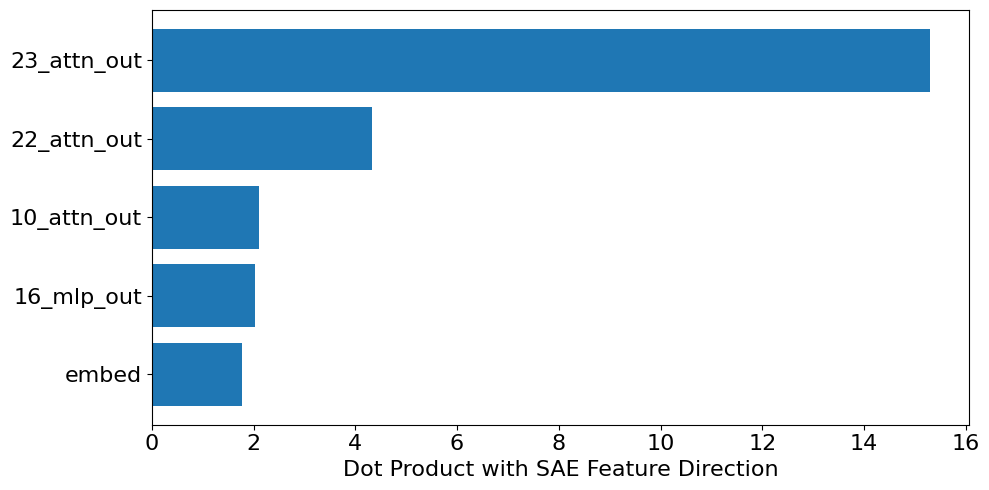

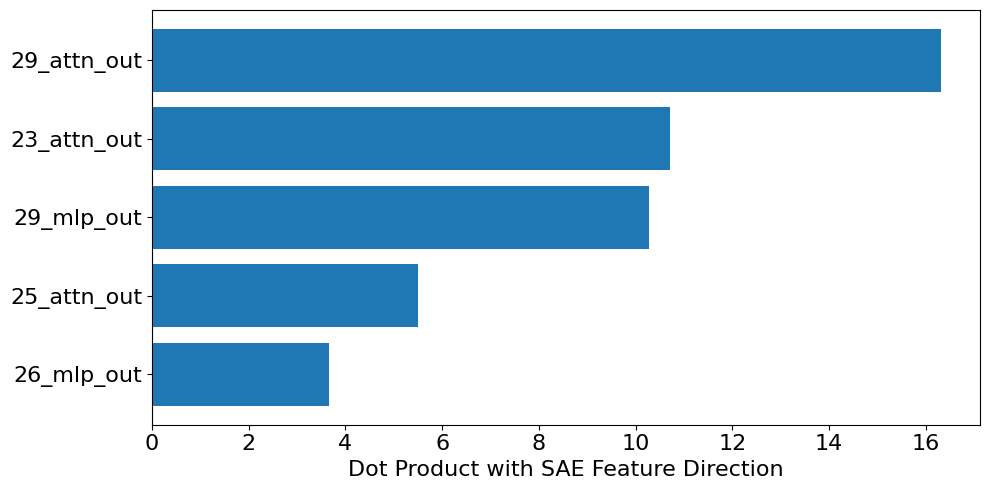

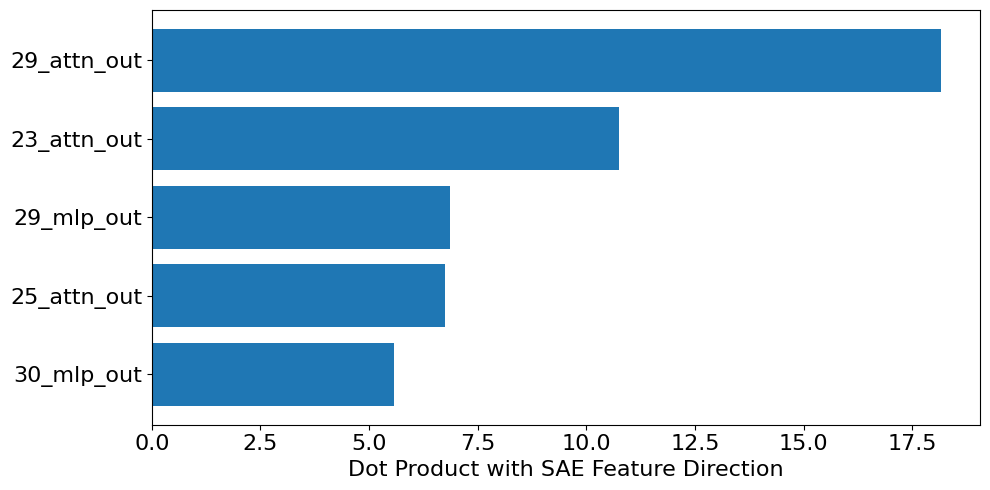

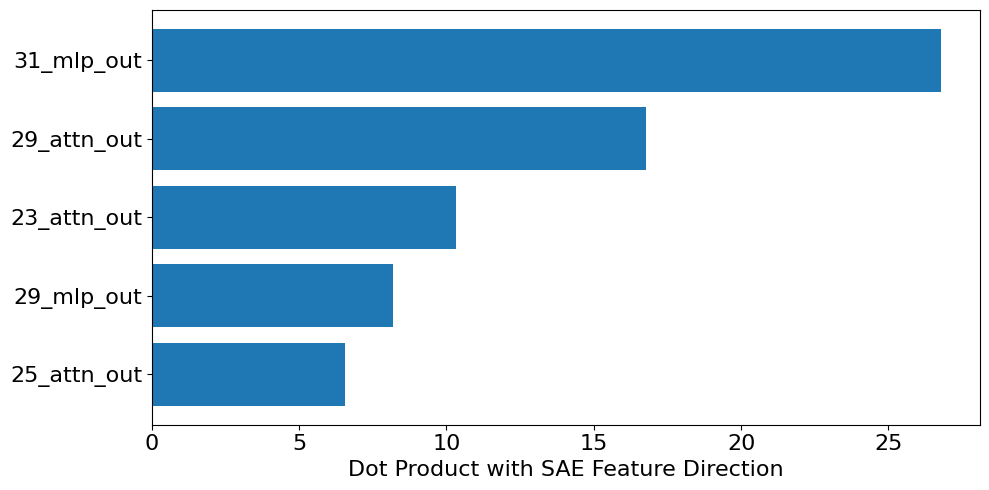

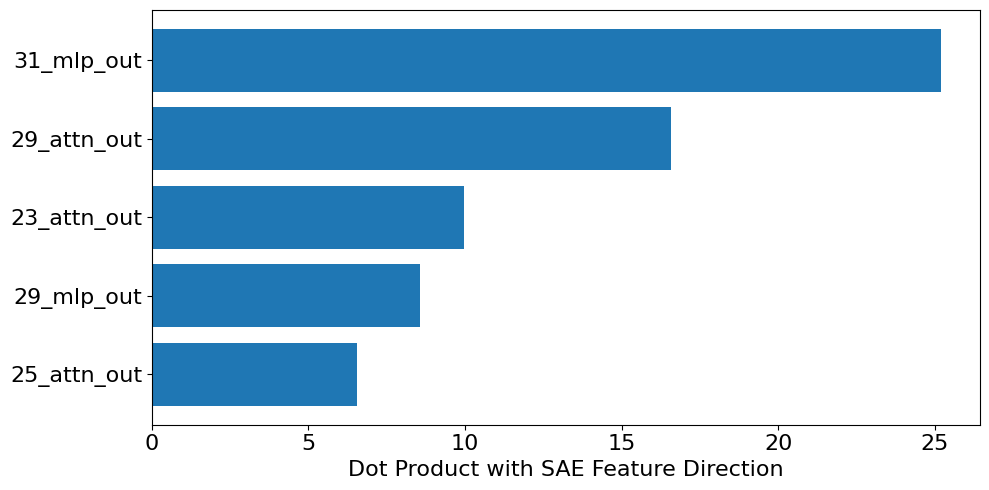

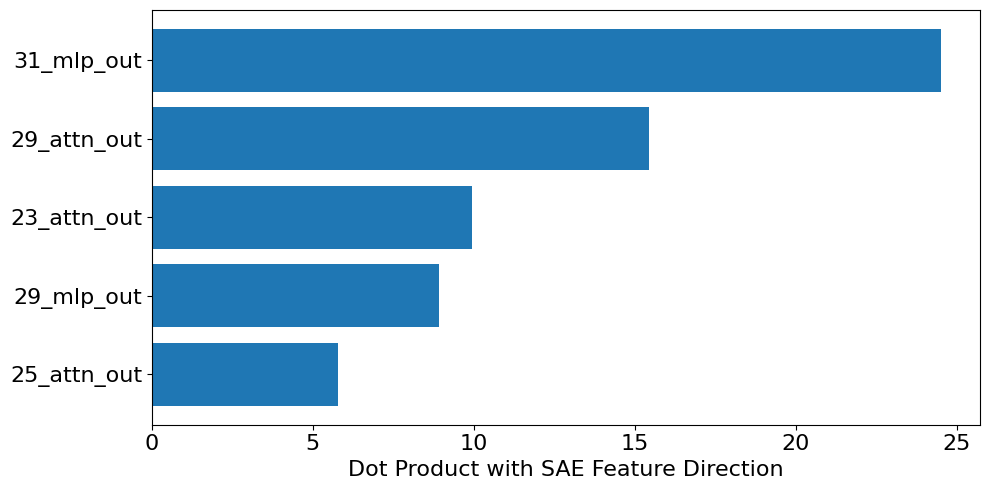

In [ ]:
%matplotlib inline
for layer in [23,29,30,31,32,33]:
    sae, _, _ = SAE.from_pretrained(
        release='gemma-scope-9b-pt-res-canonical',
        sae_id=f"layer_{layer}/width_16k/canonical",
        device="cuda"
    )
    feature_idx = language_last_selected["jpn"][layer][0]
    direction = sae.W_dec[feature_idx].detach().cpu()  # [3584]
    
    _, cache = gemma_9b.run_with_cache(generate_lang_sentences("jpn", 50))
    
    token_lengths = [gemma_9b.tokenizer(p,return_tensors="pt").input_ids.shape[1] for p in generate_lang_sentences("jpn", 50)]
    last_token_indices = torch.tensor(token_lengths, dtype=torch.long) - 1  # [50]
    
    layer_idx = torch.arange(2*(layer+1)+1).unsqueeze(1)         # [61, 1]
    batch_idx = torch.arange(50).unsqueeze(0)         # [1, 50]
    token_idx = last_token_indices.unsqueeze(0) 
    
    tensor, label = cache.decompose_resid(layer+1, return_labels=True)
    resid_components = tensor[layer_idx, batch_idx, token_idx].cpu()
    mean_resid = resid_components.mean(dim=1)
    dot_contributions = torch.matmul(mean_resid, direction)
    
    # Option B: cosine similarity (shows directional alignment)
    # cos_contributions = F.cosine_similarity(mean_resid, direction.unsqueeze(0), dim=1)
    
    # Step 4: Visualize top contributors
    
    topk = 5
    values, indices = dot_contributions.topk(topk)
    top_labels = [label[i] for i in indices]
    plt.figure(figsize=(10, 5))
    plt.barh(range(topk), values.numpy()[::-1])
    plt.xticks(fontsize=16)
    plt.yticks(range(topk), top_labels[::-1], fontsize=16)
    plt.xlabel("Dot Product with SAE Feature Direction", fontsize=16)
    # plt.title(f"Top Contributors to Chinese Feature Direction at Layer {layer}")
    plt.tight_layout()
    plt.show()

French

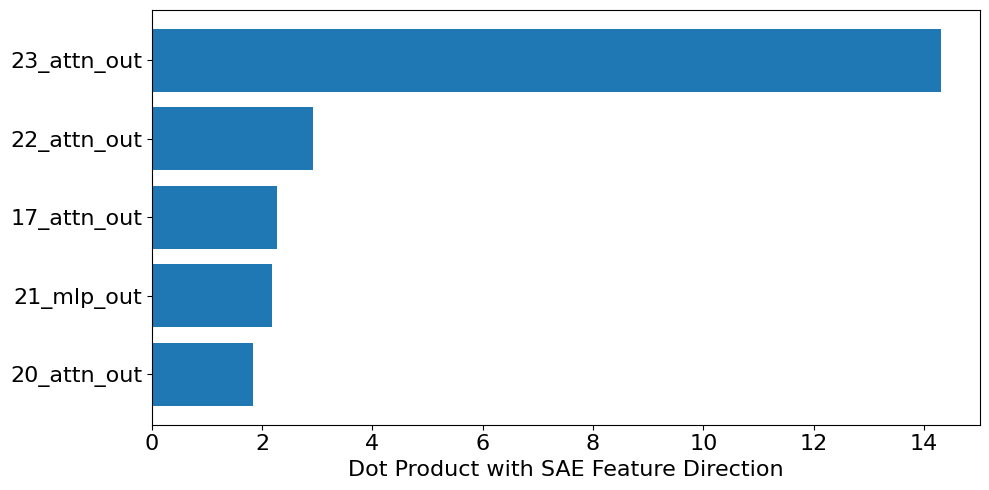

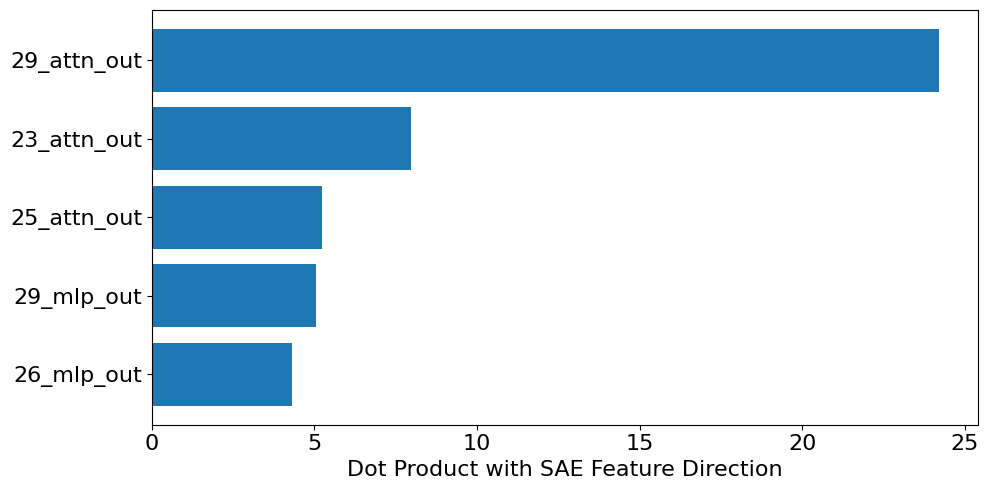

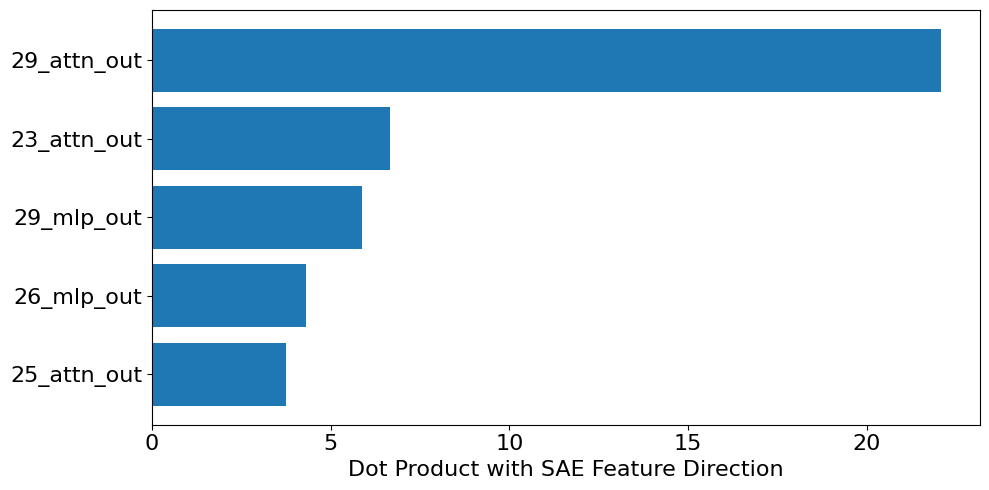

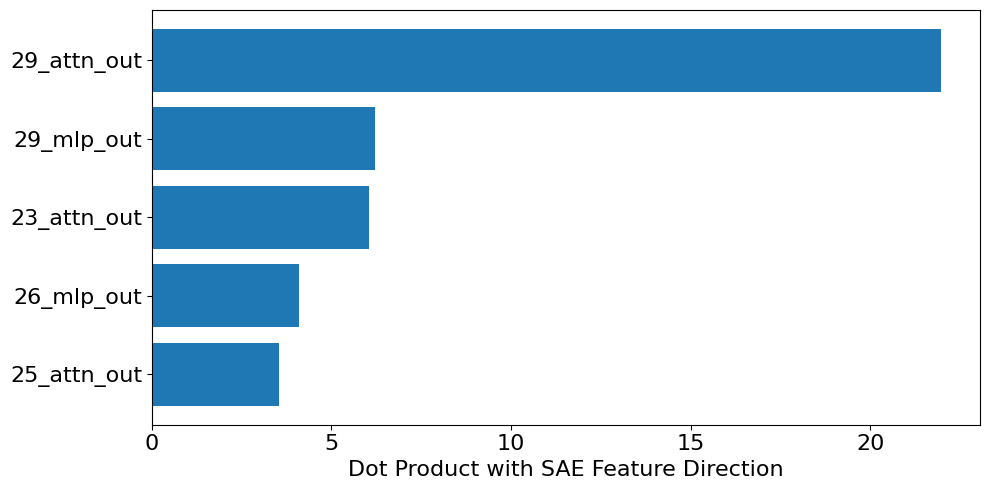

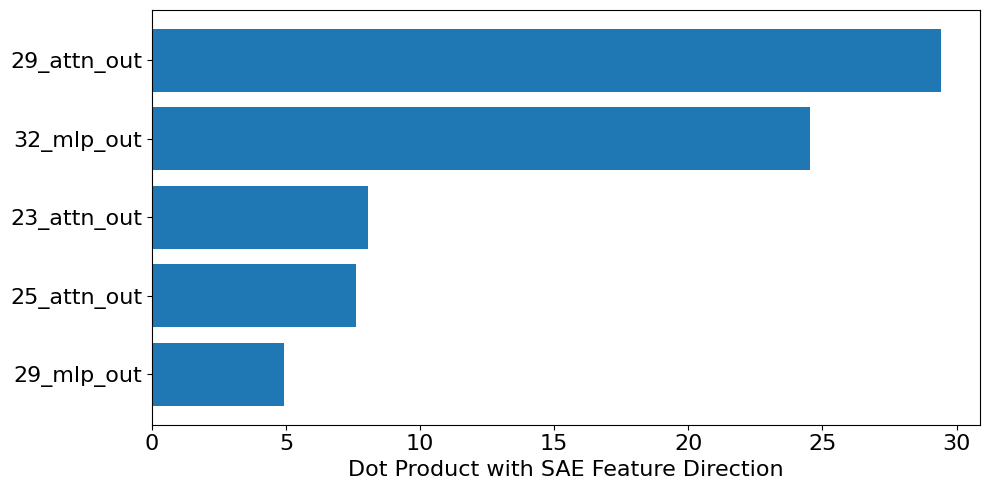

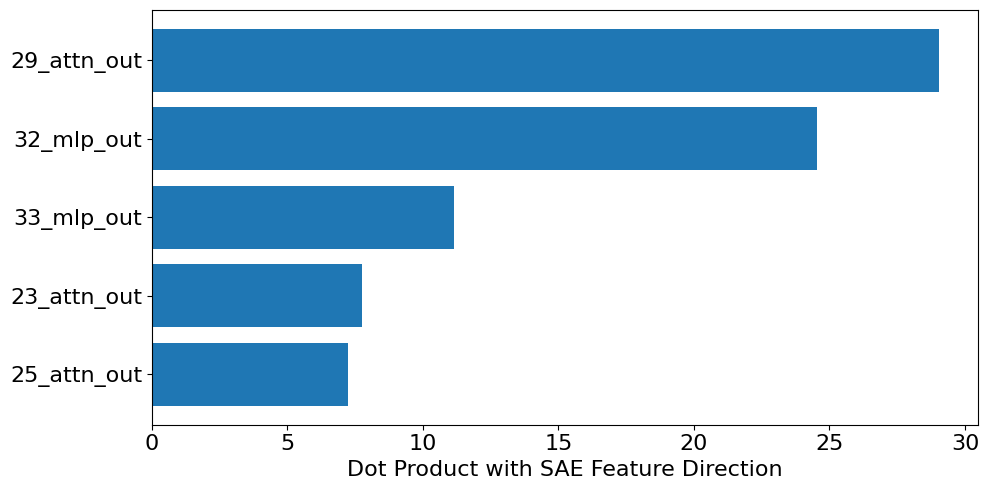

In [ ]:
%matplotlib inline
for layer in [23,29,30,31,32,33]:
    sae, _, _ = SAE.from_pretrained(
        release='gemma-scope-9b-pt-res-canonical',
        sae_id=f"layer_{layer}/width_16k/canonical",
        device="cuda"
    )
    feature_idx = language_last_selected["fra"][layer][0]
    direction = sae.W_dec[feature_idx].detach().cpu()  # [3584]
    
    _, cache = gemma_9b.run_with_cache(generate_lang_sentences("fra", 50))
    
    token_lengths = [gemma_9b.tokenizer(p,return_tensors="pt").input_ids.shape[1] for p in generate_lang_sentences("fra", 50)]
    last_token_indices = torch.tensor(token_lengths, dtype=torch.long) - 1  # [50]
    
    layer_idx = torch.arange(2*(layer+1)+1).unsqueeze(1)         # [61, 1]
    batch_idx = torch.arange(50).unsqueeze(0)         # [1, 50]
    token_idx = last_token_indices.unsqueeze(0) 
    
    tensor, label = cache.decompose_resid(layer+1, return_labels=True)
    resid_components = tensor[layer_idx, batch_idx, token_idx].cpu()
    mean_resid = resid_components.mean(dim=1)
    dot_contributions = torch.matmul(mean_resid, direction)
    
    # Option B: cosine similarity (shows directional alignment)
    # cos_contributions = F.cosine_similarity(mean_resid, direction.unsqueeze(0), dim=1)
    
    # Step 4: Visualize top contributors
    
    topk = 5
    values, indices = dot_contributions.topk(topk)
    top_labels = [label[i] for i in indices]
    plt.figure(figsize=(10, 5))
    plt.barh(range(topk), values.numpy()[::-1])
    plt.xticks(fontsize=16)
    plt.yticks(range(topk), top_labels[::-1], fontsize=16)
    plt.xlabel("Dot Product with SAE Feature Direction", fontsize=16)
    # plt.title(f"Top Contributors to Chinese Feature Direction at Layer {layer}")
    plt.tight_layout()
    plt.show()

Spanish

params.npz:   0%|          | 0.00/470M [00:00<?, ?B/s]

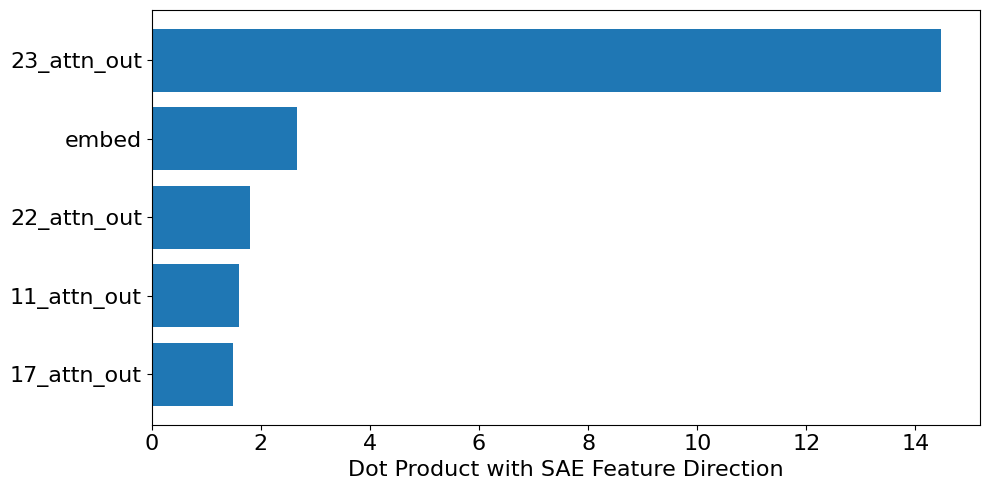

params.npz:   0%|          | 0.00/470M [00:00<?, ?B/s]

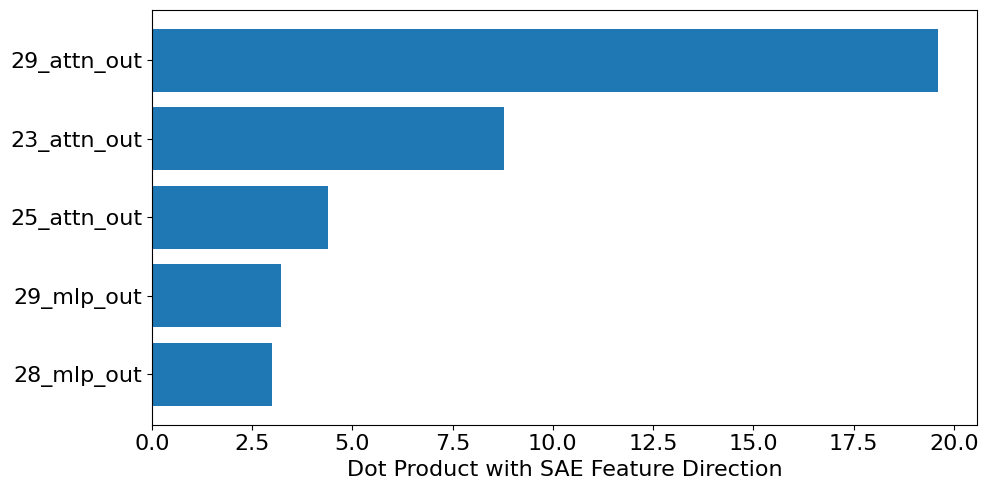

params.npz:   0%|          | 0.00/470M [00:00<?, ?B/s]

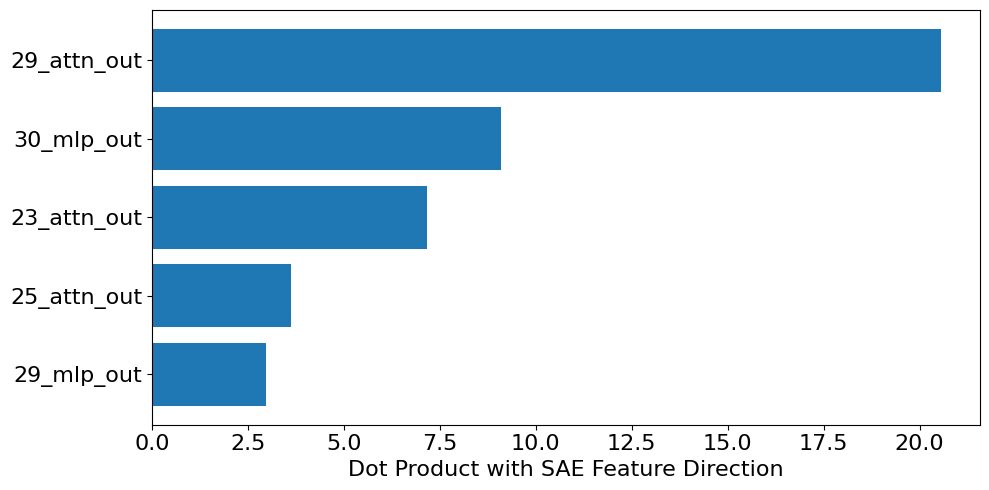

params.npz:   0%|          | 0.00/470M [00:00<?, ?B/s]

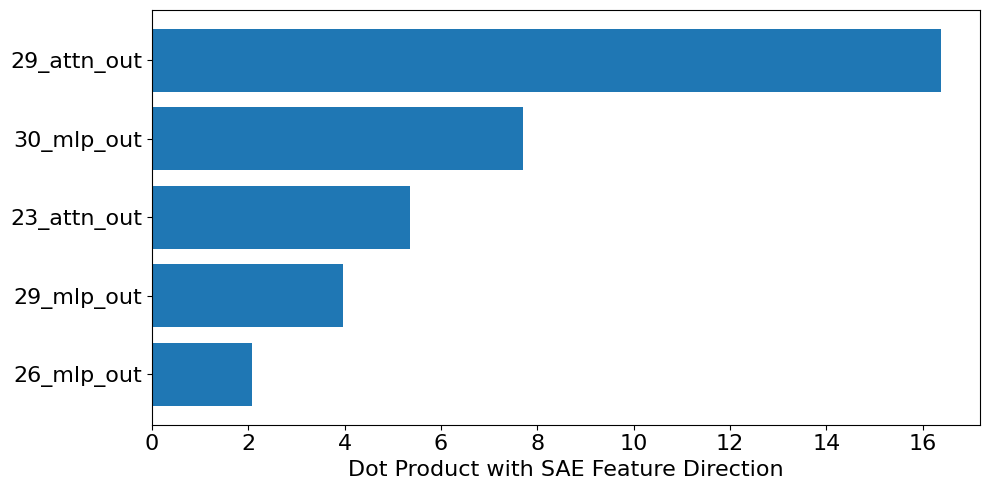

params.npz:   0%|          | 0.00/470M [00:00<?, ?B/s]

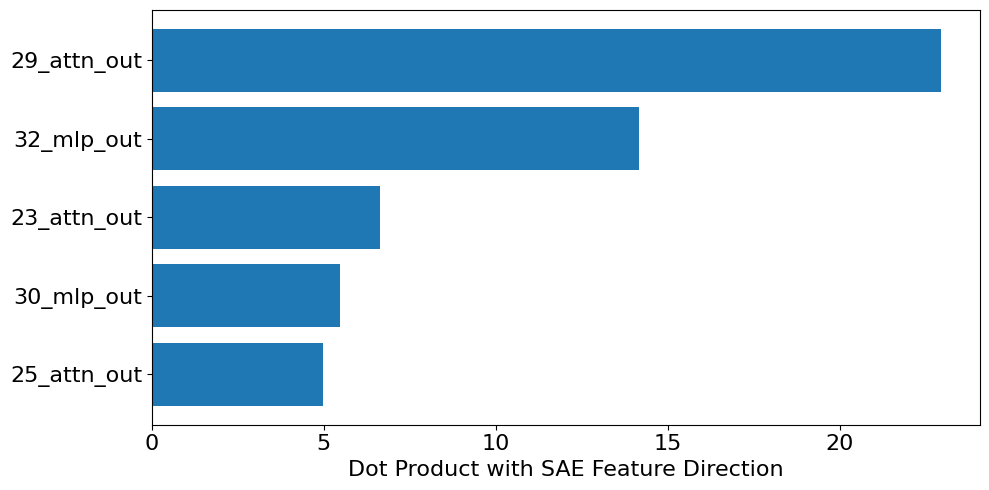

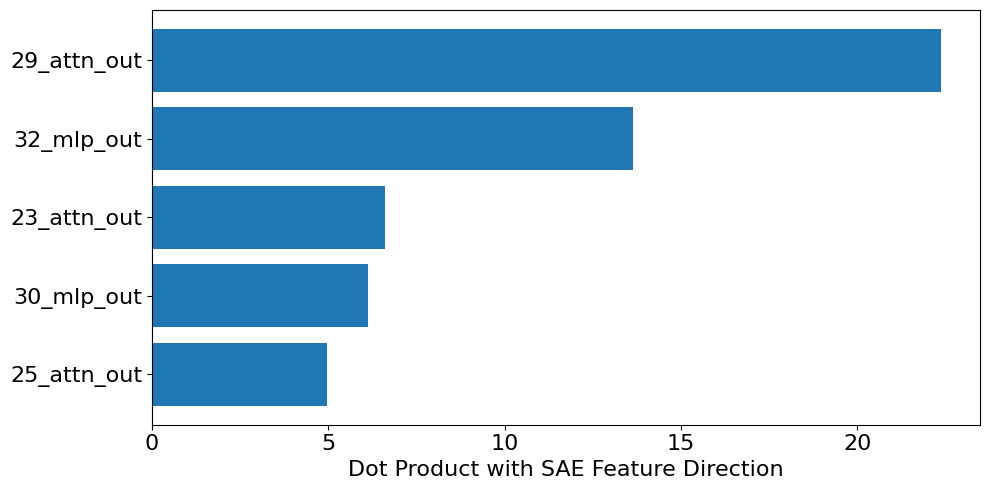

In [ ]:
%matplotlib inline
for layer in [23,29,30,31,32,33]:
    sae, _, _ = SAE.from_pretrained(
        release='gemma-scope-9b-pt-res-canonical',
        sae_id=f"layer_{layer}/width_16k/canonical",
        device="cuda"
    )
    feature_idx = language_last_selected["spa"][layer][0]
    direction = sae.W_dec[feature_idx].detach().cpu()  # [3584]
    
    _, cache = gemma_9b.run_with_cache(generate_lang_sentences("spa", 50))
    
    token_lengths = [gemma_9b.tokenizer(p,return_tensors="pt").input_ids.shape[1] for p in generate_lang_sentences("spa", 50)]
    last_token_indices = torch.tensor(token_lengths, dtype=torch.long) - 1  # [50]
    
    layer_idx = torch.arange(2*(layer+1)+1).unsqueeze(1)         # [61, 1]
    batch_idx = torch.arange(50).unsqueeze(0)         # [1, 50]
    token_idx = last_token_indices.unsqueeze(0) 
    
    tensor, label = cache.decompose_resid(layer+1, return_labels=True)
    resid_components = tensor[layer_idx, batch_idx, token_idx].cpu()
    mean_resid = resid_components.mean(dim=1)
    dot_contributions = torch.matmul(mean_resid, direction)
    
    # Option B: cosine similarity (shows directional alignment)
    # cos_contributions = F.cosine_similarity(mean_resid, direction.unsqueeze(0), dim=1)
    
    # Step 4: Visualize top contributors
    
    topk = 5
    values, indices = dot_contributions.topk(topk)
    top_labels = [label[i] for i in indices]
    plt.figure(figsize=(10, 5))
    plt.barh(range(topk), values.numpy()[::-1])
    plt.xticks(fontsize=16)
    plt.yticks(range(topk), top_labels[::-1], fontsize=16)
    plt.xlabel("Dot Product with SAE Feature Direction", fontsize=16)
    # plt.title(f"Top Contributors to Chinese Feature Direction at Layer {layer}")
    plt.tight_layout()
    plt.show()